# MLP

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [2]:
import letter_detection_utils as ld_util
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(ld_util)

<module 'letter_detection_utils' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\letter_detection_utils.py'>

In [3]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    # pickle_name='ld_sobel_y', 
    img_size=img_size,
    with_edge_detection = False
)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

Loading existing data from  ../pickle/letter_detection_data.pickle ...
Length:  1000
Imgs length:  1000
Img shape:  (4096,)


# Models

## SKLEARN MLP 

In [4]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)

In [5]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    solver='lbfgs', 
    activation='relu',
    alpha=1e-4, 
    hidden_layer_sizes=(64, 256, 1024), 
    max_iter=10_000,
    random_state=42
)
# {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024)}
mlp.fit(X_train, y_train)

print(mlp.score(X_test, y_test))
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

0.205


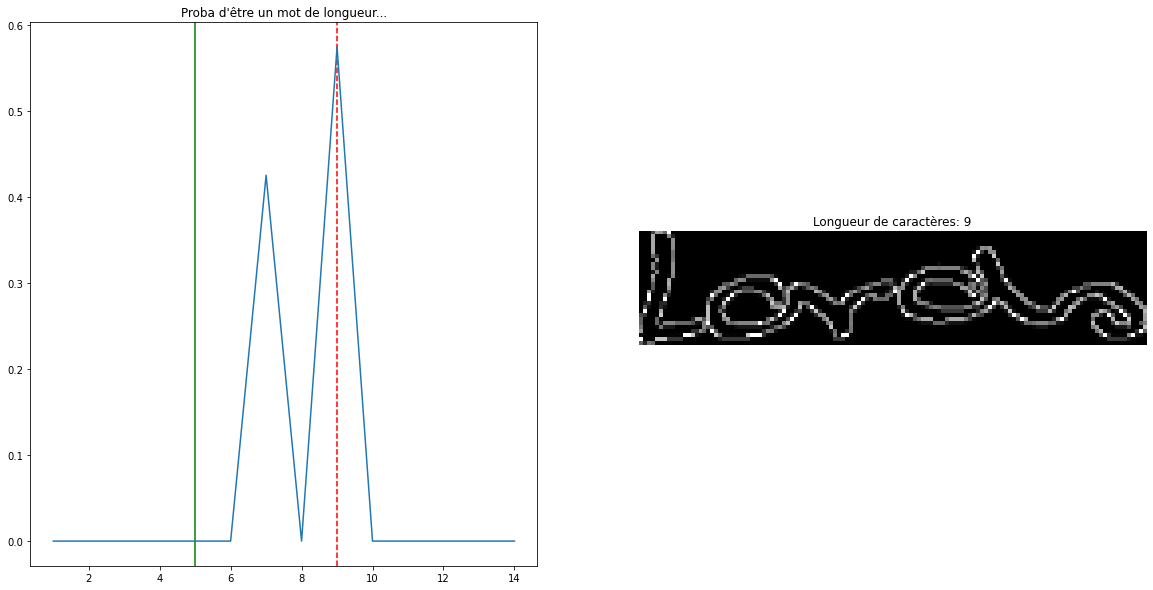

In [6]:
ld_util.show_mlp_result_for_row(X_test, y_test, y_pred, y_pred_proba, 0)

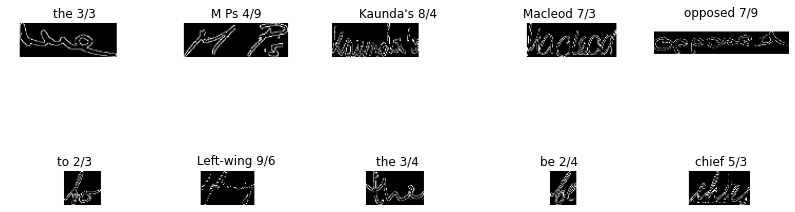

In [7]:
plt.figure(figsize=(14, 5))
j = 1
for i in np.random.randint(low=800, high=1000, size=[10]):
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(X_test[i - 800].reshape(img_size), cmap='gray');
    plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length) + '/' + str(y_pred[i - 800]))
    j+=1

## TF MLP

In [8]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)

In [9]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical



inputs = Input(shape=(X_train.shape[1]))
first_layer = Dense(16, activation='tanh', name='Dense_1')
second_layer = Dense(24, activation='tanh', name='Dense_2')
third_layer = Dense(df.length.max(), activation='linear', name='Dense_3')

outputs=first_layer(inputs)
outputs=second_layer(outputs)
outputs=third_layer(outputs)
model = Model(inputs = inputs, outputs = outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 Dense_1 (Dense)             (None, 16)                65552     
                                                                 
 Dense_2 (Dense)             (None, 24)                408       
                                                                 
 Dense_3 (Dense)             (None, 15)                375       
                                                                 
Total params: 66,335
Trainable params: 66,335
Non-trainable params: 0
_________________________________________________________________


In [11]:
import tensorflow as tf

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
training_history = model.fit(X_train, y_train, batch_size=5, epochs=20)


Epoch 1/20
133/160 [=======================>......] - ETA: 0s - loss: 6.9715 - accuracy: 0.1143

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\TiBo\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\TiBo\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\TiBo\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\TiBo\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\TiBo\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\TiBo\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\TiBo\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\TiBo\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\TiBo\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\TiBo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\TiBo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\TiBo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\TiBo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\TiBo\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\TiBo\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\TiBo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "c:\Users\TiBo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "c:\Users\TiBo\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\TiBo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\TiBo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\TiBo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\TiBo\AppData\Local\Temp\ipykernel_41032\307077943.py", line 5, in <cell line: 5>
      training_history = model.fit(X_train, y_train, batch_size=5, epochs=20)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 15 which is outside the valid range of [0, 15).  Label values: 15 4 3 2 4
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_695]

In [ ]:
model.predict(X_test)

array([[-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       ...,
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ]], dtype=float32)

## GridSearch MLP

- Solver: "lbfgs"
    Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neural_network import MLPClassifier


# mlp = MLPClassifier(solver='lbfgs', random_state=42, max_iter=1_000)

# params = {
#     'activation' : ['logistic', 'tanh', 'relu'],
#     'alpha': [1e-5, 1e-4, 1e-3],
#     'hidden_layer_sizes': [(2**6, 2**8), (2**6, 2**8, 2**10)],
#     # 'max_iter': [200, 500, 1_000]
# }

# grid_search = GridSearchCV(mlp, params)
# grid_search.fit(X_train, y_train)

# print('best params', grid_search.best_params_)
# print(grid_search.score(X_test, y_test))

# y_pred = grid_search.predict(X_test)
# y_pred_proba = grid_search.predict_proba(X_test)